# 1. 芯片初始化操作

In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

from util import plot_v_cond

In [2]:
chip=CHIP(PS(host="192.168.1.10", port = 7, delay=0.3, debug=0),init=True)
chip.set_device_cfg(deviceType=0)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 57195


# 2. 读器件

## 2.1 常规读操作

In [ ]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.1,tg=5)
chip.set_tia_gain(3)
print(chip.get_setting_info())

In [ ]:
voltage,cond = chip.read(row_index=[0,1,2,3],col_index=[3,4,6,7],row_value=None,col_value=None,all_tia=False,check_tia=True)
print(f"电导:{cond}us\n电压:{voltage}v")

## 2.2 自定义读操作

In [ ]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.3)
chip.set_tia_gain(1)
print(chip.get_setting_info())

In [ ]:

chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.3)
chip.set_tia_gain(1)

# 先需要reset所有的latch
chip.set_cim_reset()

# 配置行bank
chip.set_latch([0],row=True,value=None)
# chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
# chip.set_latch([[2,4,1,3]],row=False,value=None)
chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生读脉冲, 并读出tia值
chip.generate_read_pulse()
voltage,cond, = chip.get_tia_out([k for k in range(16)])

plot_v_cond(v= voltage,cond= cond)

## 2.3 阵列读

In [ ]:
chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)
chip.ps.debug = 0

In [ ]:
resv,resc = np.zeros((256,256)),np.zeros((256,256))
for k in range(32):
    row = k*8
    vres0,cres0 = chip.read2(row_index=[row,row+2,row+4,row+6],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)
    vres1,cres1 = chip.read2(row_index=[row+1,row+3,row+5,row+7],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)

    for j in range(4):
        # print(resv[row+j*2],vres0[j])
        resv[row+j*2]=vres0[j]
        resv[row+1+j*2]=vres1[j]

        resc[row+j*2]=cres0[j]
        resc[row+1+j*2]=cres1[j]

# 3. 写器件

## 3.1 常规写操作

In [ ]:
chip.set_op_mode(read=False,row=True)
chip.set_dac_write_V(0.1)
chip.set_pulse_width(0.1)
print(chip.get_setting_info())

In [ ]:
chip.write_one(row_index=0,col_index=0)

## 3.2 自定义写操作

In [ ]:
chip.set_op_mode(read=False,row=True)
chip.set_dac_write_V(0.1)
chip.set_pulse_width(0.1)
print(chip.get_setting_info())

In [ ]:
# 先需要reset所有的latch
chip.set_cim_reset()

# 配置行bank
chip.set_latch([2,4,253,255],row=True,value=None)
chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
chip.set_latch([[2,4,1,3]],row=False,value=None)
chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生写配置
chip.generate_write_pulse()

# 测试

### 测试新版加速代码

In [ ]:
# 行0,列53
# 行0,列66
# 行0,列79
# 行0,列92
# 行0,列103
# 行0,列168
# 行0,列181
# 行0,列194
# 行0,列231
chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)   
vres,cres = chip.read2(row_index=[0,1,2,3],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)

In [ ]:
chip.ps.debug = 3
for i in range(256*16):
    print(f"第{i}次")
    voltage,cond = chip.adc.get_out2(num=16,dout_ram_start=0,read_voltage=0.1)

In [ ]:
chip.ps.debug = 3

chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)                        # 第四步设置, TIA增益
for row in range(78):
    print(f"第{row}次读")
    vres,cres = chip.read2(row_index=[0],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)

In [ ]:
chip.ps.debug = False
chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)
for row in range(256):
    print(f"第{row}行")
    vres,cres = chip.read2(row_index=[row],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)
    plot_v_cond(vres[0],cres[0],figsize=(16,4))


In [12]:
chip.set_op_mode(read=False,row=True)
chip.set_dac_write_V(0.1)
chip.set_pulse_width(0.1)
print(chip.get_setting_info())

操作模式: write	器件: ReRAM	写电压: 0.1v	从行\列给电压: 行	脉宽: 10000000


In [ ]:
# 行0,列53
# 行0,列66
# 行0,列79
# 行0,列92
# 行0,列103
# 行0,列168
# 行0,列181
# 行0,列194
# 行0,列231

In [6]:
chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)
chip.ps.debug = 0

In [8]:
resv,resc = np.zeros((256,256)),np.zeros((256,256))
for k in range(32):
    row = k*8
    vres0,cres0 = chip.read2(row_index=[row,row+2,row+4,row+6],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)
    vres1,cres1 = chip.read2(row_index=[row+1,row+3,row+5,row+7],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)

    for j in range(4):
        # print(resv[row+j*2],vres0[j])
        resv[row+j*2]=vres0[j]
        resv[row+1+j*2]=vres1[j]

        resc[row+j*2]=cres0[j]
        resc[row+1+j*2]=cres1[j]

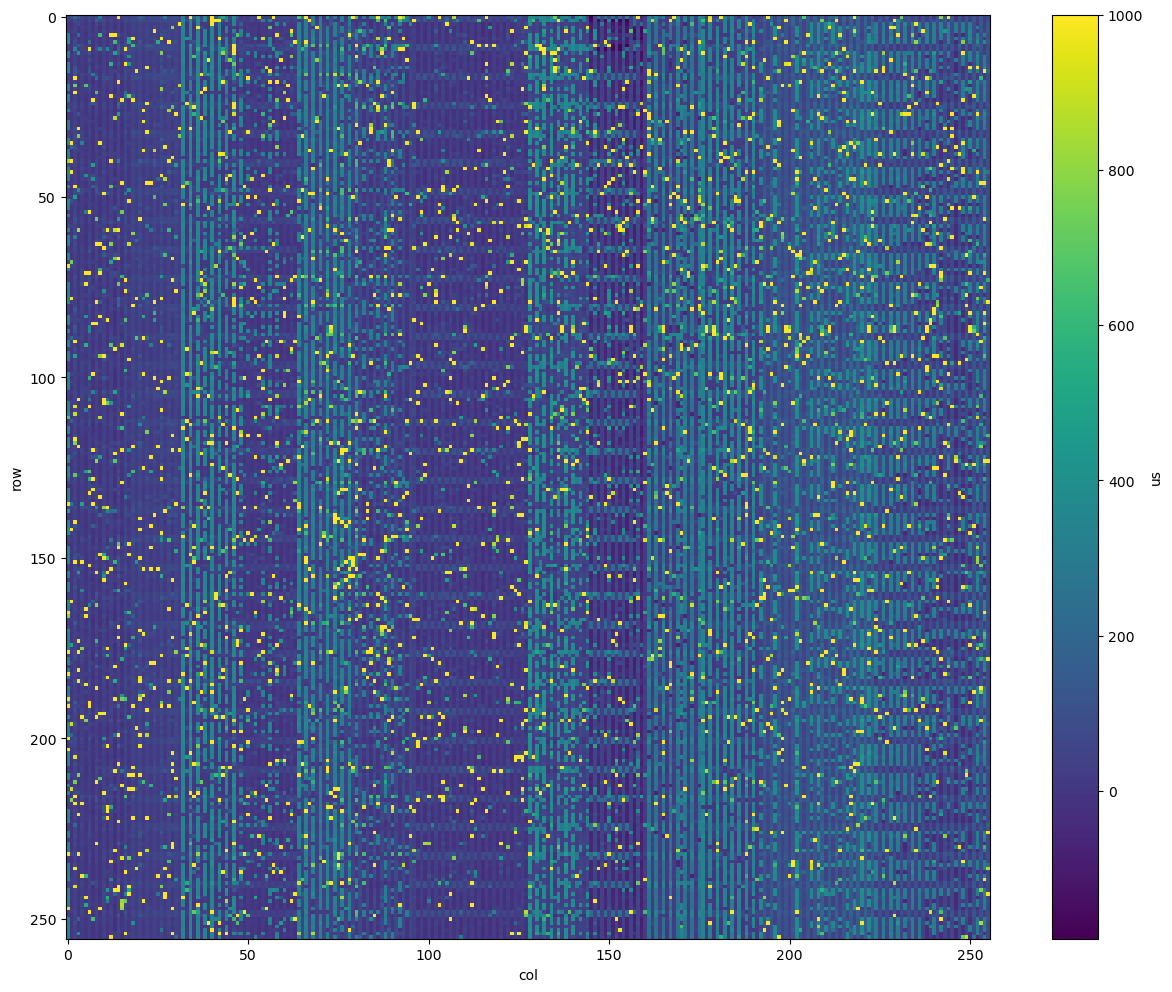

In [15]:
resc2 = np.zeros((256,256))
for i in range(256):
    for j in range(256):
        if resc[i][j]>1000:
            resc2[i][j]=1000
        else:
            resc2[i][j]=resc[i][j]

plt.figure(figsize=(16,12))
plt.imshow(resc2)  # 你可以选择其他的colormap, 例如'viridis', 'plasma', 'inferno'等
cbar = plt.colorbar()  # 显示色标
cbar.set_label("us")
plt.xlabel('col')  # 设置X轴标签
plt.ylabel('row')  # 设置Y轴标签
plt.show()  # 显示图像

0 14 0.21149327066866053
0 66 0.2151936399426252
0 86 0.2562028870509964
0 92 0.2761162144840846
0 103 0.23751029999694817
0 116 0.11059144871364482
0 158 0.16270180364391001
0 168 0.24906918546098208
0 178 0.11585589159825435
0 181 0.2807702871791742
0 194 0.20558030945768607
0 218 0.20916623432111575
0 244 0.23548844874416333


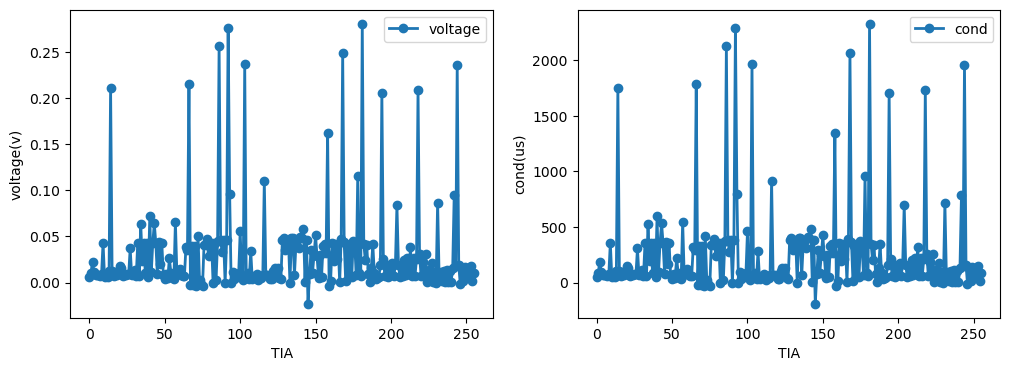

In [210]:
chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)
vres,cres = chip.read2(row_index=[0],col_index=[i for i in range(256)],read_voltage=0.1,tg=5,check_tia=True,sum=False)

row, col = vres.shape
for i in range(row):
    for j in range(col):
        if vres[i,j]>0.1:
            print(i,j,vres[i,j])
plot_v_cond(vres[0],cres[0])

In [74]:
# chip.set_op_mode2(read=True,row=True)
# chip.set_tia_gain(1)
print(chip.read2(row_index=[0],col_index=[2,34,66,98,130],read_voltage=0.1,tg=5))


(array([[0.01651814, 0.1882992 , 0.25528733, 0.00328074, 0.09189886]]), array([[ 137.10050661, 1562.88244948, 2118.88358021,   27.23012371,
         762.76009336]]))


In [98]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.1,tg=5)
chip.set_tia_gain(1)
print(chip.get_setting_info())
print(chip.read(row_index=[0],col_index=[2,34,66,98,130]))

操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1
操作模式: read	器件: ReRAM	读电压: 0.1v	从行\列给电压: 行	TIA增益: 1


(array([0.01518296, 0.18673513, 0.25414289, 0.00297555, 0.05195776]), array([ 126.01847952, 1549.90064632, 2109.38469985,   24.69708895,
        431.2491686 ]))


## debug版本读

In [ ]:
# 坏点，14，66,86,92,103
# 66

In [211]:
chip.ps.debug=1

row = 0
col = 116
res1=[]
res2=[]
res3=[]


pulse_width = 0.1
chip.set_pulse_width(pulse_width)
chip.set_tia_gain(1)  


chip.set_op_mode2(read=True,row=True)
vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=0.1,tg=5,check_tia=True)
print(vres,cres)

print("---------------------------------------reset---------------------------------------")
chip.set_op_mode2(read=False,row=False)
chip.set_pulse_width(pulse_width)
chip.write2(row_index=[row],col_index=[col],write_voltage=1.3,tg=5)

chip.set_op_mode2(read=True,row=True)
vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=0.1,tg=5,check_tia=True)
print(vres,cres)
res2.append(vres[0])


print("---------------------------------------set---------------------------------------")
chip.set_op_mode2(read=False,row=True)
chip.set_pulse_width(pulse_width)
chip.write2(row_index=[row],col_index=[col],write_voltage=5,tg=2)

# --------------------------------------------------------------- 读
chip.set_op_mode2(read=True,row=True)
vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=0.1,tg=5,check_tia=True)
print(vres,cres)
res3.append(vres[0])

模式: 1
	帧头:          	字节码: 55 aa 01
	指令: pulse_cyc	字节码: 1b 00 98 96 80

指令完整字节码:  55aa011b00989680
模式: 1
	帧头:     	字节码: 55 aa 01
	指令: gain	字节码: 10 00 00 00 01

指令完整字节码:  55aa011000000001
模式: 4
	帧头:               	字节码: 55 aa 04
	指令: pl_ram_addr   	字节码: 00 00
	指令: pl_data_length	字节码: 00 0c
	指令: pl_dac_v      	字节码: 03 00 00 00
	指令: pl_dac_v      	字节码: 03 01 00 00
	指令: pl_dac_v      	字节码: 03 02 00 00
	指令: pl_dac_v      	字节码: 03 03 00 00
	指令: pl_dac_v      	字节码: 03 04 00 00
	指令: pl_dac_v      	字节码: 03 05 00 00
	指令: pl_dac_v      	字节码: 03 06 00 00
	指令: pl_dac_v      	字节码: 03 07 00 00
	指令: pl_dac_v      	字节码: 03 08 00 00
	指令: pl_dac_v      	字节码: 03 09 00 00
	指令: pl_dac_v      	字节码: 03 0a 00 00
	指令: pl_dac_v      	字节码: 03 0b 00 00
模式: 1
	帧头:               	字节码: 55 aa 01
	指令: ins_num       	字节码: 1c 00 00 00 0c
模式: 1
	帧头:               	字节码: 55 aa 01
	指令: fast_command_1	字节码: 01 00 00 80 00

指令完整字节码:  55aa040000000c03000000030100000302000003030000030400000305000003060000030700000308000003090000030

In [199]:
row = 0
col = 116
res1=[]
res2=[]
res3=[]

pulse_width = 0.1
chip.ps.debug=0
chip.set_pulse_width(pulse_width)
chip.set_tia_gain(1)

chip.set_op_mode2(read=True,row=True)
vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=0.1,tg=5,check_tia=True)
print(vres,cres)


for i in range(1):
    print("---------------------------------------reset---------------------------------------")
    # # --------------------------------------------------------------- reset
    chip.set_op_mode(read=False,row=False)
    chip.set_pulse_width(pulse_width)
    chip.set_dac_write_V(1.2,tg=5)
    chip.write_one(row_index=row,col_index=col)
    time.sleep(pulse_width+0.1)
    # chip.write2(row_index=[row],col_index=[col],write_voltage=0.9,tg=5)
    # chip.write2(row_index=[row],col_index=[col],write_voltage=0.9,tg=5)

    chip.set_op_mode2(read=True,row=True)
    vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=0.1,tg=5,check_tia=True)
    print(vres,cres)
    res2.append(vres[0])
    print("---------------------------------------set---------------------------------------")
    # --------------------------------------------------------------- forming
    chip.set_op_mode(read=False,row=True)
    chip.set_pulse_width(pulse_width)
    chip.set_dac_write_V(5,tg=1.9)
    chip.write_one(row_index=row,col_index=col)
    time.sleep(pulse_width+0.1)
    # chip.write2(row_index=[row],col_index=[col],write_voltage=5,tg=1.5)
    # chip.write2(row_index=[row],col_index=[col],write_voltage=5,tg=1.5)

    # --------------------------------------------------------------- 读
    chip.set_op_mode2(read=True,row=True)
    chip.set_tia_gain(1)                        # 第四步设置, TIA增益
    vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=0.1,tg=5,check_tia=True)
    print(vres,cres)
    res3.append(vres[0])

[[0.18292032]] [[1518.23771176]]
---------------------------------------reset---------------------------------------
操作模式: write	器件: ReRAM	写电压: 1.2v	从行\列给电压: 列	脉宽: 10000000
[[0.16445662]] [[1364.98910853]]
---------------------------------------set---------------------------------------
操作模式: write	器件: ReRAM	写电压: 5v	从行\列给电压: 行	脉宽: 10000000
[[0.16560106]] [[1374.4879889]]


In [ ]:
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(res2, marker='o', linestyle='-', linewidth=2,label="reset")
plt.plot(res3, marker='o', linestyle='-', linewidth=2,label="formig")
plt.legend()
plt.show()

In [ ]:
chip.set_op_mode(read=False,row=True)
chip.set_dac_write_V(5,tg=1.2)
chip.set_tia_gain(1)
chip.set_pulse_width(1)
chip.write_one(row_index=row,col_index=col)
time.sleep(1.2)


chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)                        # 第四步设置, TIA增益
vres,cres = chip.read2(row_index=[row],col_index=[col],read_voltage=0.1,tg=5,check_tia=True,all_tia=False)
print(vres)
res3.append(vres[0])

In [ ]:
plt.figure()
plt.ylabel("v")
plt.xlabel("TIA")
plt.plot(res2, marker='o', linestyle='-', linewidth=2,label="reset")
plt.plot(res3, marker='o', linestyle='-', linewidth=2,label="formig")
plt.legend()
plt.show()

# plt.figure()
# plt.ylabel("v")
# plt.xlabel("TIA")
# plt.plot(res3, marker='o', linestyle='-', linewidth=2,label="formig")
# plt.show()

In [ ]:
chip.set_op_mode(read=False,row=False)
chip.set_dac_write_V(5,tg=5)
chip.set_tia_gain(1)
print(chip.get_setting_info())

In [ ]:
chip.set_op_mode2(read=True,row=True)
chip.set_tia_gain(1)                        # 第四步设置, TIA增益
vres,cres = chip.read2(row_index=[0],col_index=[66],read_voltage=0.1,tg=5,check_tia=True,all_tia=False)
print(vres)

In [ ]:
chip.set_op_mode(read=False,row=False)
chip.set_pulse_width(1)
chip.write2(row_index=[0],col_index=[66],write_voltage=5,tg=5)


In [ ]:
voltage,cond = chip.get_tia_out([k for k in range(16)])
print(voltage)
plot_v_cond(voltage,cond)


In [ ]:
# chip.set_cim_reset()
# chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)
# chip.set_bank([i for i in range(8)],row=True,value=0xFFFF_FFFF)
for i in range(10):
    chip.generate_read_pulse()

    voltage,cond = chip.get_tia_out([k for k in range(16)])
    print(voltage)
    plot_v_cond(voltage,cond)

In [ ]:
for i in range(10):
    # chip.generate_read_pulse()
    voltage,cond = chip.get_tia_out([k for k in range(16)])
    print(voltage)
    plot_v_cond(voltage,cond)

In [ ]:
for i in range(20):
    # 先需要reset所有的latch
    chip.set_cim_reset()

    # 配置行bank
    chip.set_latch([0],row=True,value=None)
    chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)
    # chip.set_latch([i for i in range(256)],row=False,value=None)

    # 配置列bank
    # chip.set_latch([[2,4,1,3]],row=False,value=None)
    # chip.set_bank([i for i in range(8)],row=False,value=0xFFFF_FFFF)

    # 产生读脉冲, 并读出tia值
    chip.generate_read_pulse()
    voltage,cond, = chip.get_tia_out([k for k in range(16)])

    print(voltage)
    plot_v_cond(voltage,cond)
    if voltage[10]<0.44 or voltage[10]>0.45:
        break

In [ ]:
for i in range(20):
    voltage,cond = chip.read(row_index=[0],col_index=[i for i in range(256)],row_value=None,col_value=None,all_tia=True,check_tia=False)
    plot_v_cond(voltage,cond)

In [37]:
op_bank_cfg_done_delay_cyc = 1000
op_cim_data_cfg_done_delay_cyc = 1000
reg_clk_done_delay_cyc = 1000
latch_clk_done_delay_cyc = 1000
# op_adc_avrg_done_delay_cyc = 1000
# op_dac_cfg_done_delay_cyc = 1000
# op_row_pulse_done_delay_cyc = 1000
# op_col_pulse_done_delay_cyc = 1000
# op_cim_rstn_done_delay_cyc = 1000

pkts=Packet()
pkts.append_cmdlist([
    # CMD(OP_BANK_CFG_DONE_DELAY_CYC,command_data=CmdData(1000)),
    CMD(OP_CIM_DATA_CFG_DONE_DELAY_CYC,command_data=CmdData(10000)),
    CMD(REG_CLK_DONE_DELAY_CYC,command_data=CmdData(10000)),
    CMD(LATCH_CLK_DONE_DELAY_CYC,command_data=CmdData(10000)),
    # CMD(OP_ADC_AVRG_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_DAC_AVRG_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_ROW_PULSE_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_COL_PULSE_DONE_DELAY_CYC,command_data=CmdData(1000)),
    # CMD(OP_CIM_RSTN_DONE_DELAY_CYC,command_data=CmdData(1000)),
],mode=1)
chip.ps.send_packets(pkts)

## debug读一行

In [59]:
chip.set_op_mode(read=True,row=True)
chip.set_dac_read_V(0.1,tg=5)
chip.set_tia_gain(1)

In [ ]:
chip.set_cim_reset()
chip.generate_read_pulse()
print(chip.get_tia_out([i for i in range(16)])[0])

In [ ]:
# 行0,列53
# 行0,列66
# 行0,列79
# 行0,列92
# 行0,列103
# 行0,列168
# 行0,列181
# 行0,列194
# 行0,列231

In [ ]:
chip.set_dac_read_V(0.1,tg=5)
voltage,cond = chip.read(row_index=[0],col_index=[i for i in range(256)],row_value=None,col_value=None,check_tia=False)
plot_v_cond(voltage[0],cond[0])


chip.set_dac_read_V(0.5,tg=5)
voltage,cond = chip.read(row_index=[0],col_index=[i for i in range(256)],row_value=None,col_value=None,check_tia=False)
plot_v_cond(voltage[0],cond[0])
# chip.set_dac_read_V(0.3,tg=5)
# voltage,cond = chip.read(row_index=[0],col_index=[i for i in range(256)],row_value=None,col_value=None,check_tia=True)
# plot_v_cond(voltage,cond)